# Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$ так, чтобы сохранить структуру соседства.

    1. Вероятностная постановка задачи


Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$
так, чтобы сохранить структуру соседства.


        - Вероятности в исходном пространстве

Гауссово ядро для измерения сходства:

$
p_{j|i} = exp(-||x_i - x_j||^2 / (2σ_i^2)) / Σ_{k≠i} exp(-||x_i - x_k||^2 / (2σ_i^2))$

Симметризация вероятностей:

$
p_{ij} = (p_{j|i} + p_{i|j}) / (2n)$

Перплексия (perplexity) как гиперпараметр:

$
Perp(P_i) = 2^{H(P_i)}, $

где $H(P_i) = -Σ_j p_{j|i} log₂ p_{j|i}$

        - Вероятности в целевом пространстве

Распределение Стьюдента с одной степенью свободы:

$
q_{ij} = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}$

Преимущества t-распределения:

       * Тяжелые хвосты

       * Устойчивость к проклятию размерности

       * Улучшенное разделение кластеров

       * Функция стоимости (KL-дивергенция)

$C(Y) = KL(P||Q) = Σ_i Σ_j p_{ij} log(p_{ij} / q_{ij})$

    2. Оптимизация функции стоимости

        2.1. Градиент функции стоимости

$∂C/∂y_i = 4 Σ_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

       2.2. Методы оптимизации

Градиентный спуск с моментумом:

$Y^{(t)} = Y^{(t-1)} + η ∂C/∂Y + α(t)(Y^{(t-1)} - Y^{(t-2)})$


Раннее преувеличение (early exaggeration):


$p_{ij} ← p_{ij} × 4 (первые 100 итераций)$


Адаптивное обучение (adaptive learning rate)

        2.3. Сложности оптимизации

            - Невыпуклость функции стоимости

            - Локальные минимумы

            - Чувствительность к начальной инициализации

            - Вычислительная сложность O(n²)

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Задание

1. Провести исследование влияния гиперпараметров на результаты кластеризации с T-SNE
2. Сравнить с PCA
   
Использовать 2 датасета - стандартного типа Ирис или Цифры, и своего. Не забываем про нормировку и eda в целом

In [2]:
df = pd.read_csv('drug.csv')

label_mapping = {
    0: "Good",
    1: "Bad",
}

df['Label'] = df['Label'].map(label_mapping)
df


,Label,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Good,1.484,743.207,21.466,18.764,18.764,14.292,12.106,12.106,10.736,...,0,0,0,0,0,0,0,0,0,0
1,Bad,1.472,868.947,21.140,16.736,17.553,14.453,10.268,11.084,7.662,...,0,0,0,0,0,0,0,0,0,0
2,Good,0.837,1409.004,39.189,32.904,32.904,26.011,20.941,20.941,18.816,...,0,0,0,0,0,0,0,0,0,0
3,Bad,2.406,621.298,13.828,10.297,10.297,9.092,5.847,5.847,4.217,...,0,0,0,0,0,0,0,0,0,0
4,Good,1.320,2127.996,37.955,30.849,31.666,25.910,18.066,19.115,14.930,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Good,1.508,1127.109,26.361,19.925,20.742,16.973,11.450,12.330,9.200,...,1,0,0,0,0,0,0,0,0,1
116,Good,2.678,608.396,11.544,8.689,8.689,7.720,4.765,4.765,3.399,...,0,0,0,0,0,0,0,0,0,0
117,Good,1.670,593.488,15.364,13.294,14.110,10.775,8.338,9.217,6.177,...,0,0,0,0,0,0,0,1,0,0
118,Good,2.603,902.371,22.422,17.683,17.683,14.167,9.469,9.469,7.070,...,0,0,0,0,0,0,0,0,1,0


In [3]:
from sklearn.datasets import load_digits

# 1. Загрузка данных
digits = load_digits()
X = digits.data
y = digits.target

Разделить выборку на фичи и целевую переменную

In [4]:
feature_cols = 'Label'
my_X = df.drop(feature_cols, axis=1)
my_y = df[feature_cols]

print(my_X.shape, my_y.shape)

(120, 196) (120,)


Нормировка

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
my_X_scaled = scaler.fit_transform(my_X)

pca = PCA(n_components=2, random_state=42)

Доля объяснённой дисперсии: [0.12033916 0.09561054] Суммарно: 0.21594970500832789


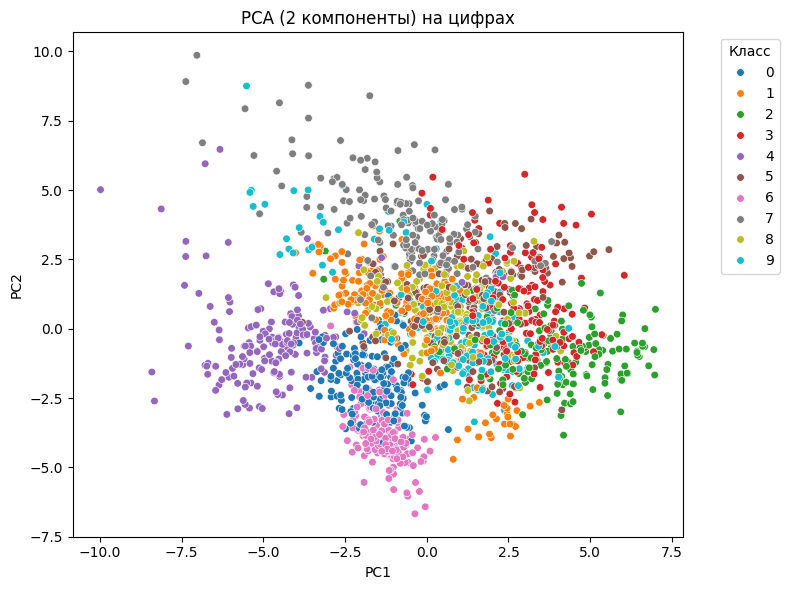

In [6]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии:",   pca.explained_variance_ratio_,
      "Суммарно:",  pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10", s=30)
plt.title("PCA (2 компоненты) на цифрах")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Доля объяснённой дисперсии: [0.2102381  0.08225824] Суммарно: 0.2924963386514543


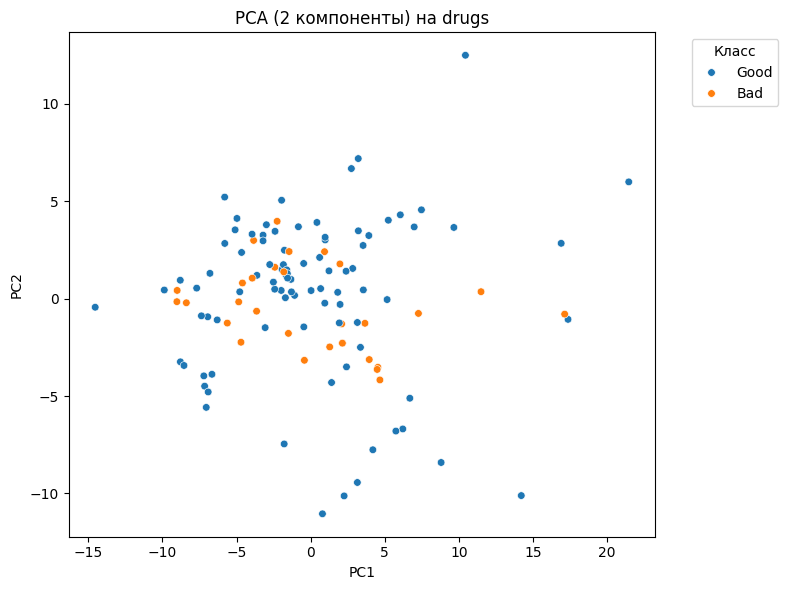

In [7]:
pca = PCA(n_components=2, random_state=42)
my_X_pca = pca.fit_transform(my_X_scaled)

print("Доля объяснённой дисперсии:",   pca.explained_variance_ratio_,
      "Суммарно:",  pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=my_X_pca[:, 0], y=my_X_pca[:, 1], hue=my_y, palette="tab10", s=30)
plt.title("PCA (2 компоненты) на drugs")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


TSNE 2 компоненты

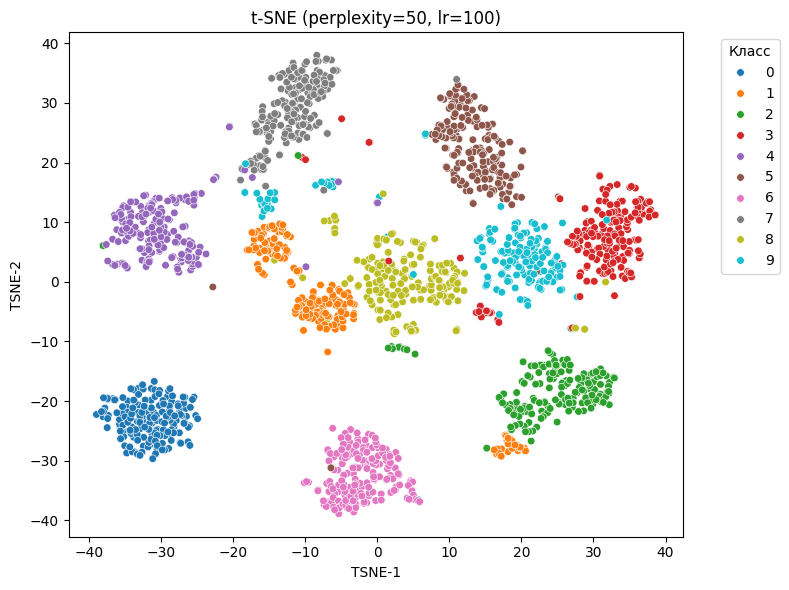

In [8]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate=100,
    perplexity=50
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", s=30)
plt.title(f"t-SNE (perplexity={tsne.perplexity}, lr={tsne.learning_rate})")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


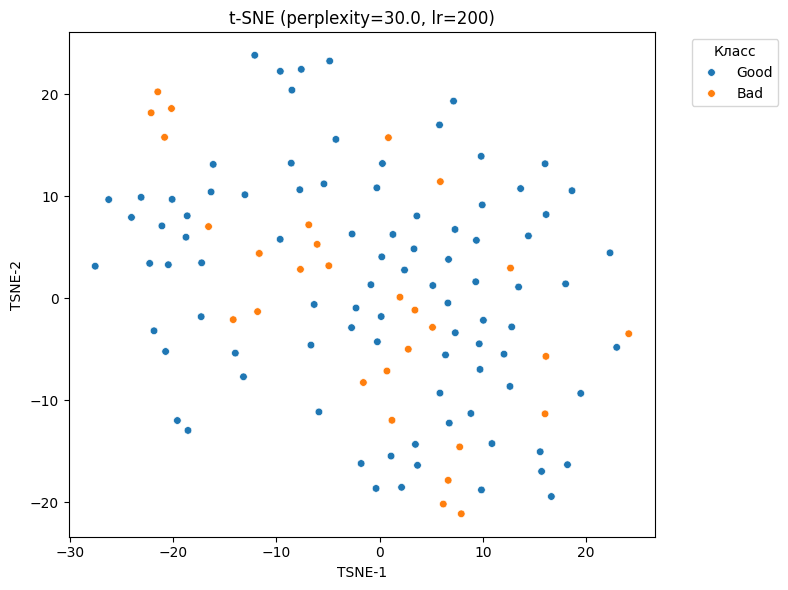

In [9]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate=200
)

my_X_tsne = tsne.fit_transform(my_X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=my_X_tsne[:, 0], y=my_X_tsne[:, 1], hue=my_y, palette="tab10", s=30)
plt.title(f"t-SNE (perplexity={tsne.perplexity}, lr={tsne.learning_rate})")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    D = pairwise_distances(X_2d)
    same = D[y[:, None] == y[None, :]]
    diff = D[y[:, None] != y[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)


PCA:  среднее расстояние внутри класса = 2.468234399163823 , между классами = 4.761456156687811 , ratio = 1.9290939945982744
t-SNE: среднее расстояние внутри класса = 9.793342 , между классами = 39.39175 , ratio = 4.0222993


In [11]:
my_pca_same, my_pca_diff, my_pca_ratio = separation_score(my_X_pca, np.array(my_y))
my_tsne_same, my_tsne_diff, my_tsne_ratio = separation_score(my_X_tsne, np.array(my_y))

print("PCA:  среднее расстояние внутри класса =", my_pca_same,
      ", между классами =", my_pca_diff,
      ", ratio =", my_pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", my_tsne_same,
      ", между классами =", my_tsne_diff,
      ", ratio =", my_tsne_ratio)


PCA:  среднее расстояние внутри класса = 8.534772717610702 , между классами = 8.097237087135813 , ratio = 0.9487349405834704
t-SNE: среднее расстояние внутри класса = 21.335945 , между классами = 21.130758 , ratio = 0.990383


Вычислить и отрисовать T-SNE с разным значением Perplexity

In [12]:
perplexities = [5, 30, 50, 100]
learning_rates = [50, 200, 1000, 1500]

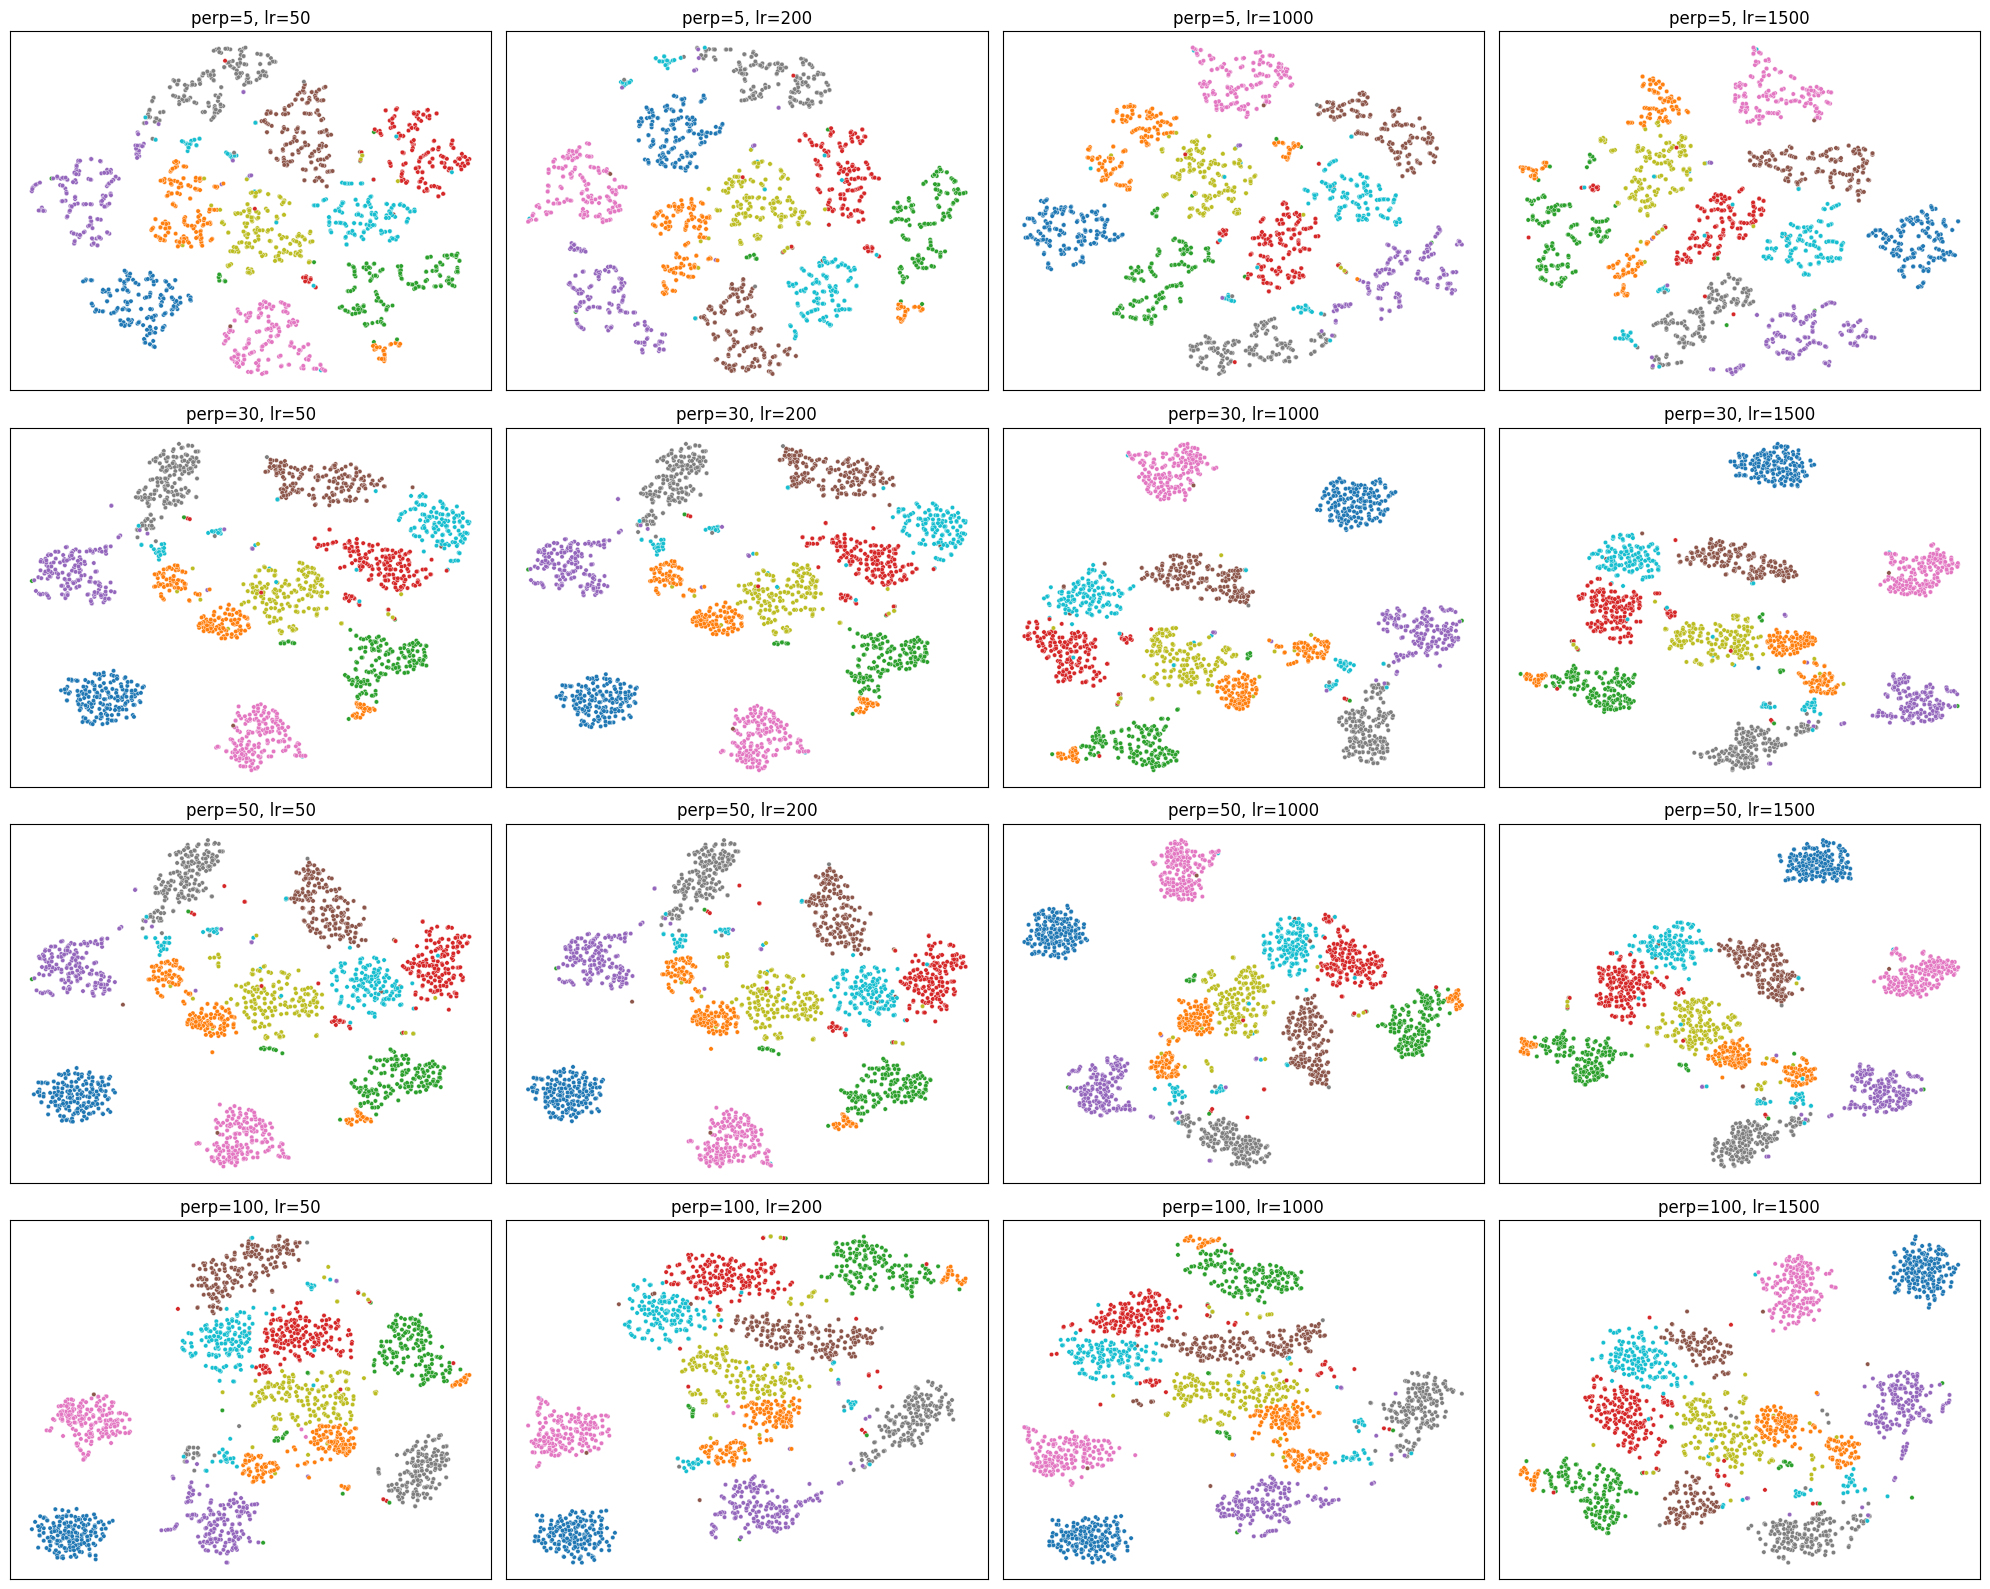

In [13]:
fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

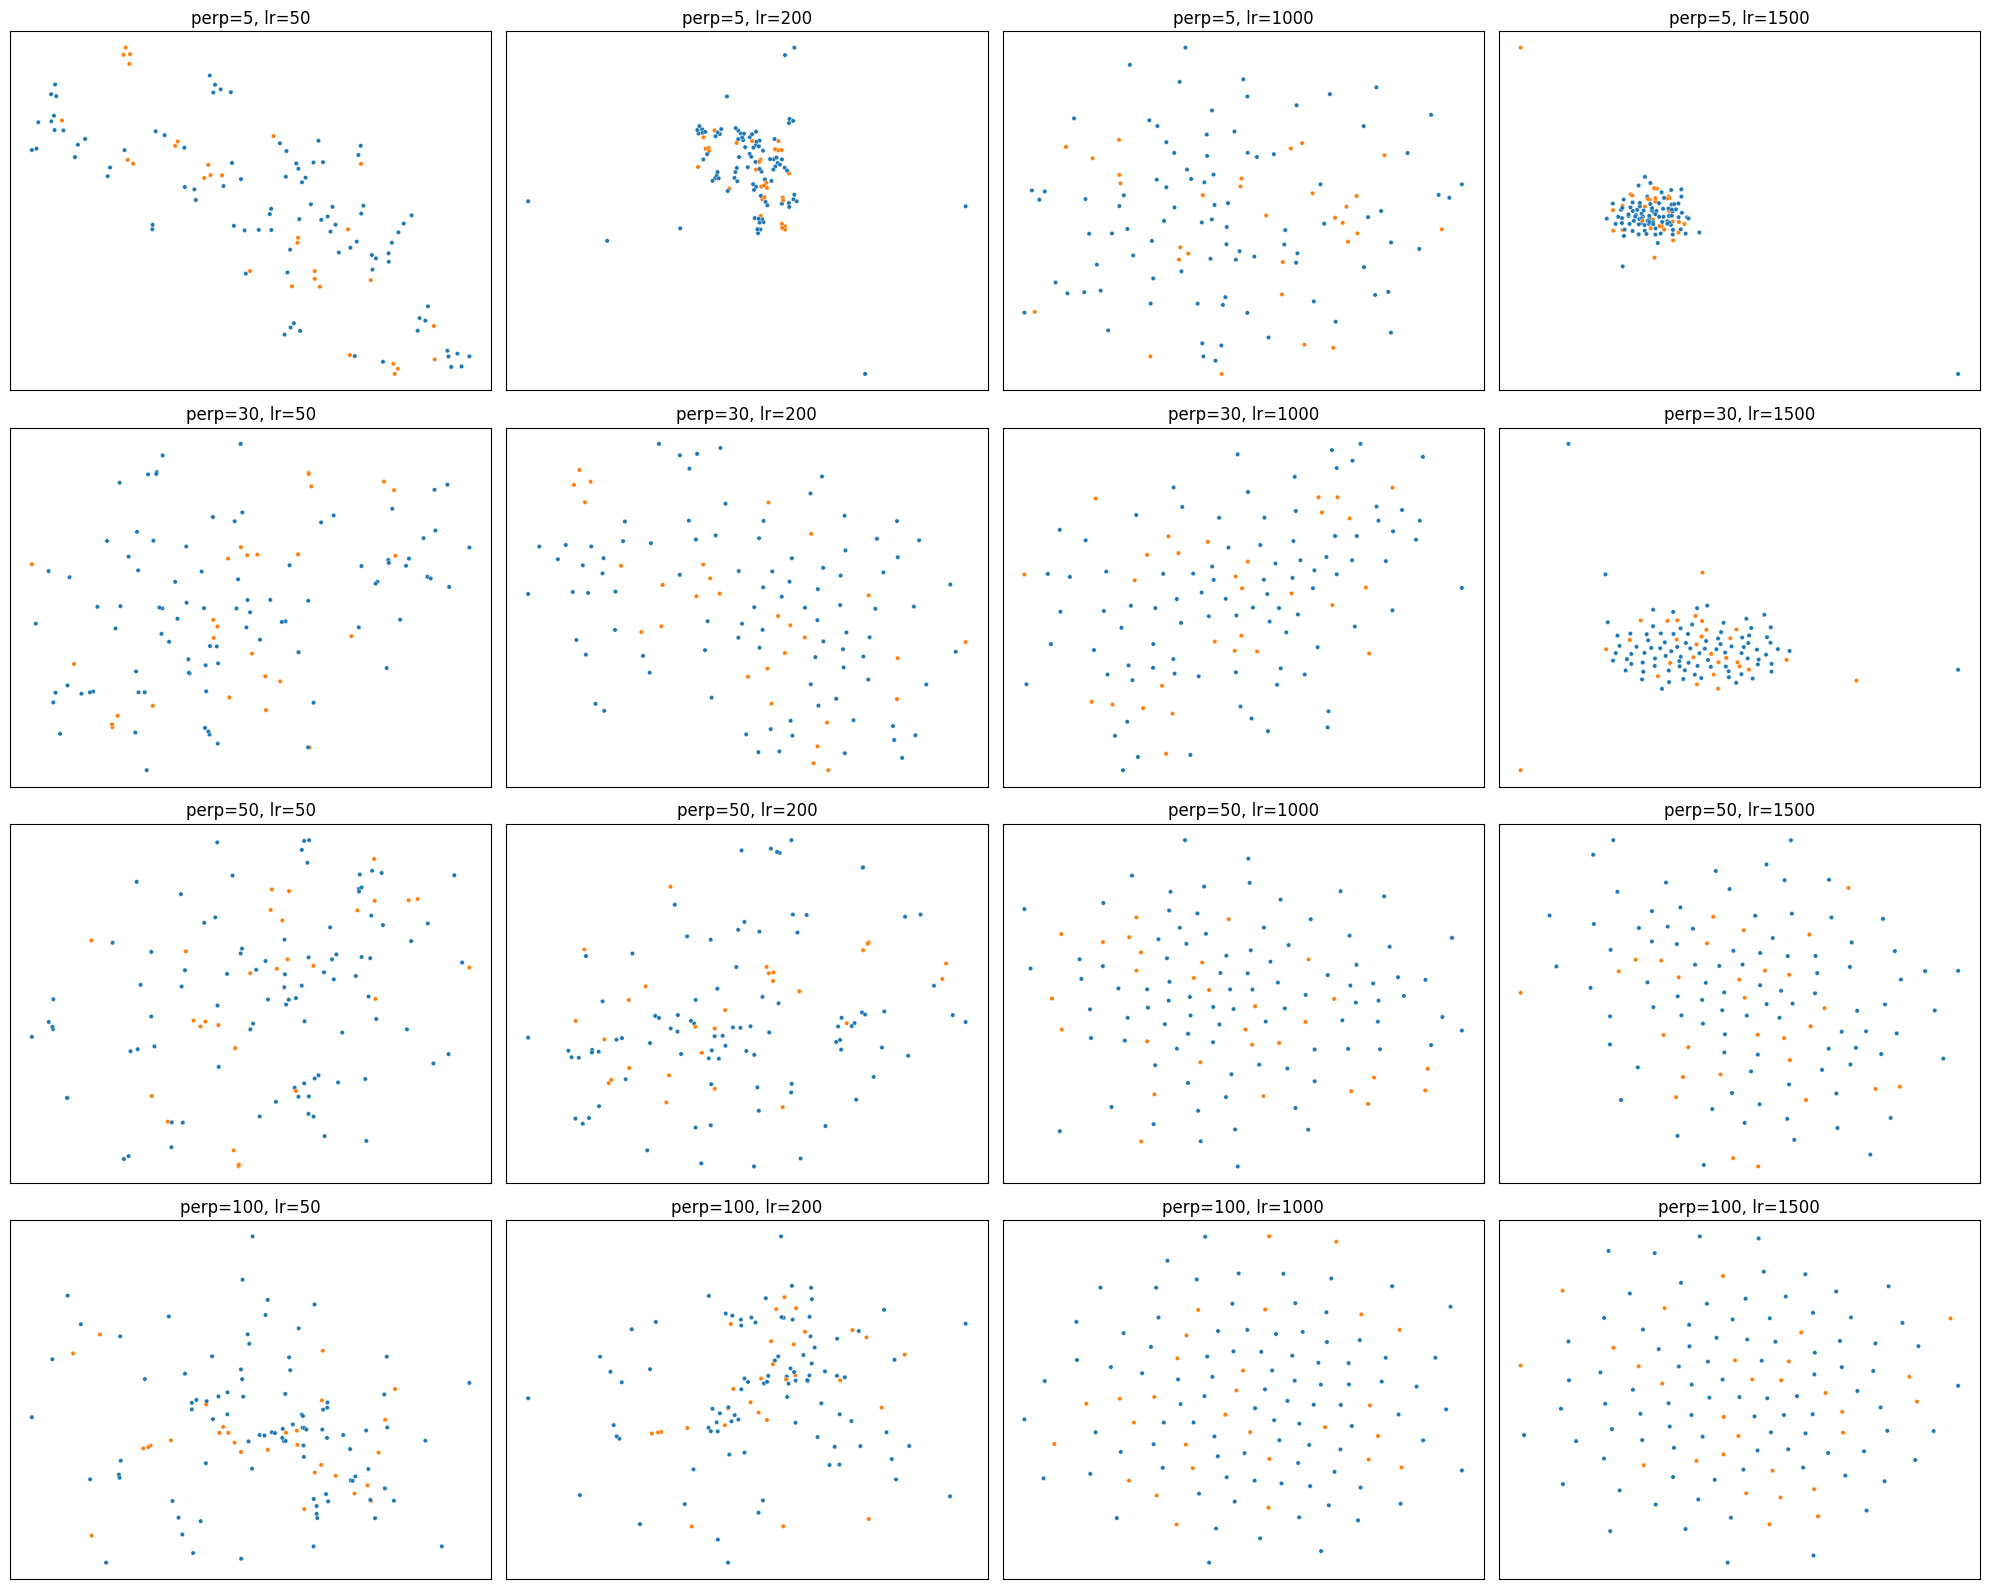

In [14]:
fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(my_X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=my_y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


* При меньших значения perplexity кластеры более разряжены, а learn rate влияет на расстояния между кластерами
* небольшие изменения perplexity влияет средне на рисунок
* небольшие изменения learn rate сильно влияет на рисунок

Проанализируйте:

как меняется форма кластеров,

возникают ли “разрывы” или слияния при разных параметрах,

насколько стабилен рисунок при небольших изменениях параметров.

PCA: устойчивая структура
Для PCA параметров немного (по сути только число компонент), проекция при фиксированном random_state практически не меняется, что показывает устойчивость метода.

Можно показать, что при разных n_components (2, 3, больше) первые две компоненты остаются близкими, а общая структура мало меняется.

In [15]:
n_components = [2, 3, 4, 5, 10]

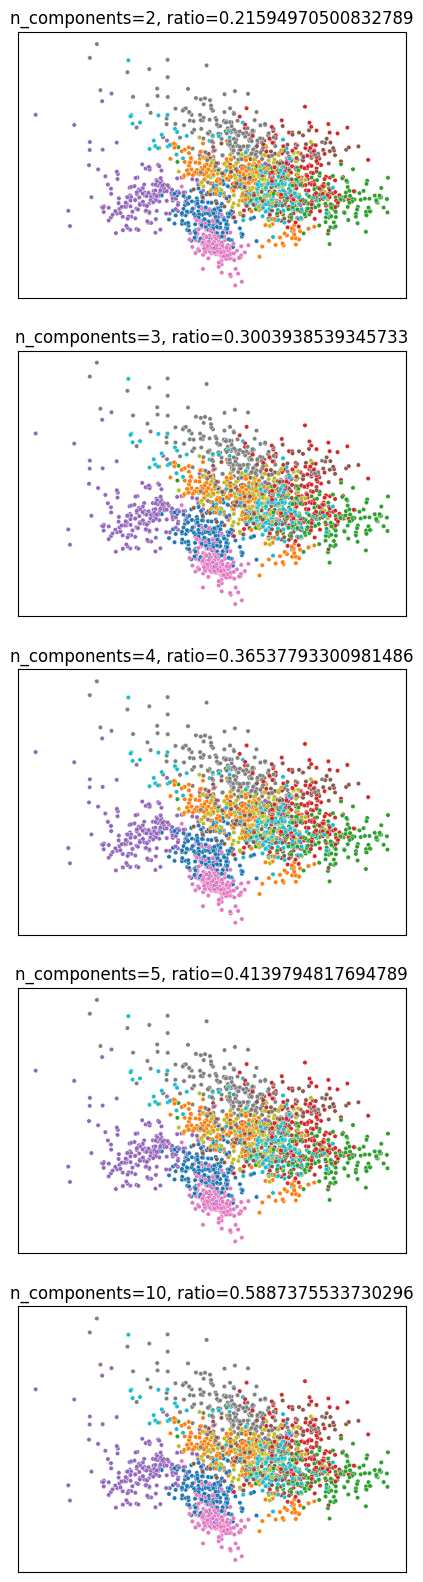

In [16]:
fig, axes = plt.subplots(len(n_components), 1, figsize=(len(n_components), 4*len(n_components)))

for i, n in enumerate(n_components):
  pca = PCA(n_components=n, random_state=42)
  X_pca = pca.fit_transform(X_scaled)

  ax = axes[i]
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=y, palette="tab10", s=10, ax=ax, legend=False)
  ax.set_title(f"n_components={n}, ratio={pca.explained_variance_ratio_.sum()}")
  ax.set_xticks([])
  ax.set_yticks([])

In [17]:
n_components = [2, 3, 4, 5]

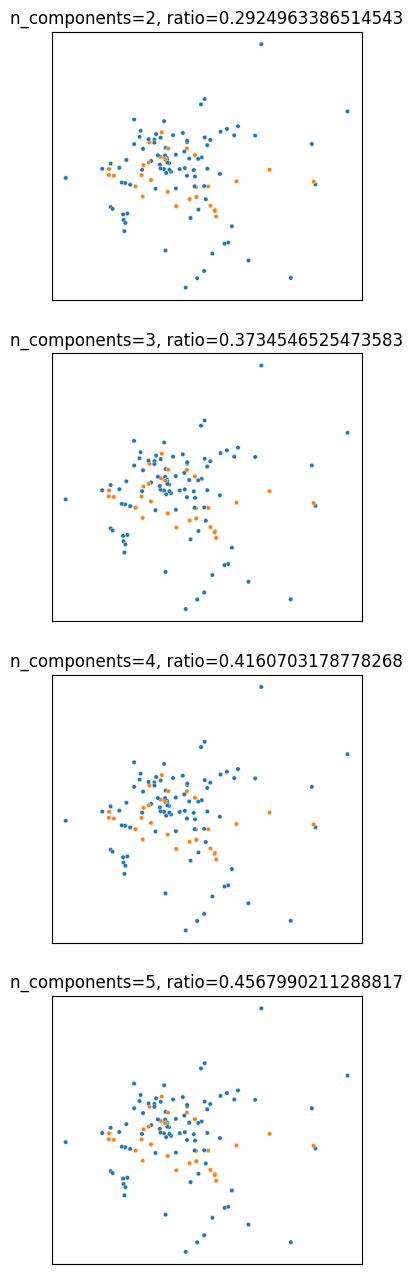

In [18]:
fig, axes = plt.subplots(len(n_components), 1, figsize=(len(n_components), 4*len(n_components)))

for i, n in enumerate(n_components):
  pca = PCA(n_components=n, random_state=42)
  X_pca = pca.fit_transform(my_X_scaled)

  ax = axes[i]
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=my_y, palette="tab10", s=10, ax=ax, legend=False)
  ax.set_title(f"n_components={n}, ratio={pca.explained_variance_ratio_.sum()}")
  ax.set_xticks([])
  ax.set_yticks([])
